In [1]:
import numpy as np
import dowhy
from dowhy import CausalModel
import dowhy.datasets
# Avoiding unnecessary log messges and warnings
import logging
logging.getLogger("dowhy").setLevel(logging.WARNING)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


# Data processing

## Importing data

In [81]:
import pandas as pd

data = pd.read_csv('2016.csv')
data = data.rename(columns={'temp,˚C': 'temp','Q, Gcal':'Q', 'М1, t':'M1', 'М2, t':'M2', 'Т1, °C':'T1', 'Т2, °C':'T2', 'ΔМ, t':'delta_M', 'ΔТ, °C':'delta_T'})

data.head()

Date      M1      M2  delta_M     T1     T2  delta_T     Q  USPD  \
0  2016/1/1  102.51   92.05    10.46  81.99  53.36    28.63  2.94     1   
1  2016/1/1  124.86  125.29    -0.43  82.58  50.24    32.34  4.05     3   
2  2016/1/1  127.31  128.51    -1.20  83.26  51.72    31.55  4.02     4   
3  2016/1/1   86.36   81.61     4.75  92.55  54.82    37.73  3.26    10   
4  2016/1/1  170.81  168.74     2.07  83.29  59.70    23.59  4.04    12   

   YYYYMM          registrated  scheme  type    area  floors walls material  \
0  201601  Heating + Hot water  opened  1105  2707.4       5          panel   
1  201601  Heating + Hot water  closed  2105  3358.4       5          brick   
2  201601  Heating + Hot water  closed  2105  3153.5       5          brick   
3  201601  Heating + Hot water  opened  1105  2646.5       5          panel   
4  201601  Heating + Hot water  closed  2105  3187.5       5          brick   

   year of construction  area of building       temp  
0                  1983            4401.0 -17.782121  
1                  1974            3610.4 -17.782121  
2                  1975            3150.2 -17.782121  
3                  1982            2932.7 -17.782121  
4                  1976            3456.2 -17.782121

## Pre-processing

In [57]:
import datetime
from datetime import datetime

data_temp_date = data.groupby("Date").temp.mean()
data_Q_date = data.groupby("Date").Q.mean()
merged_temp_Q = pd.merge(data_temp_date, data_Q_date, on='Date')
merged_temp_Q['Date'] = merged_temp_Q.index
merged_temp_Q['Date'] = pd.to_datetime(merged_temp_Q['Date'])

merged_temp_Q = merged_temp_Q.reset_index(drop=True)
merged_temp_Q = merged_temp_Q.sort_values(['Date'])

merged_temp_Q['Date']= merged_temp_Q['Date'].apply(lambda x: datetime.strftime(x,'%Y-%m-%d'))
merged_temp_Q.describe()


temp           Q
count  220.000000  220.000000
mean    -6.771093    3.302338
std     10.036346    0.864934
min    -32.582617    0.793787
25%    -13.290211    2.569404
50%     -6.160375    3.225212
75%      0.584797    3.951401
max     16.963864    5.137470

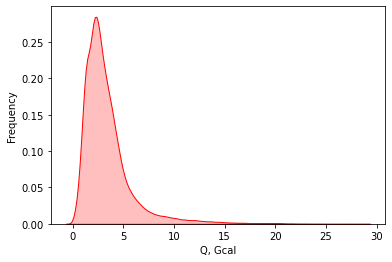

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

Q_Gcal = data[['Q']]

h = sns.kdeplot(Q_Gcal.Q, color="Red", shade = True)
h.set_xlabel("Q, Gcal")
h.set_ylabel("Frequency")
plt.show()

In [59]:
import autoBinning
from autoBinning.utils.forwardSplit import *
# sby='woeiv'时考虑woe趋势，sby='iv'时不考虑woe趋势
t = forwardSplit(data['Q'], data['Q'])
t.fit(sby='iv',minv=0.1,init_split=6)
print(t.bins) 
t = forwardSplit(data['Q'], data['Q'])
t.fit(sby='iv',num_split=6,init_split=6)
print(t.bins) 

t.fit(sby='woeiv',num_split=6,init_split=6)
print(t.bins)

print("bin\twoe")
for i in range(len(t.bins)-1):
    v = t.value[(t.x < t.bins[i+1]) & (t.x >= t.bins[i])]
    woe = t._cal_woe(v)
    print((t.bins[i], t.bins[i+1]),woe)

None
[1.000e-02 1.520e+00 2.170e+00 2.867e+01]
[1.000e-02 1.520e+00 2.170e+00 2.760e+00 3.540e+00 4.770e+00 2.867e+01]
bin	woe
(0.01, 1.52) 1.8066973640756427
(1.52, 2.17) 0
(2.17, 2.76) 0
(2.76, 3.54) 0
(3.54, 4.77) 0
(4.77, 28.67) 0


In [60]:
from pandas import Series, DataFrame
bins=[0,5,10,15,20,25,30]
bin_data = pd.cut(data['Q'], bins)
print(pd.value_counts(bin_data))

(0, 5]      140216
(5, 10]      19612
(10, 15]      3695
(15, 20]      1017
(20, 25]       242
(25, 30]        10
Name: Q, dtype: int64


In [61]:
def func(x):
    if ((x<5) & (x>0)):
        return "1"
    elif ((x>=5) & (x<10)):
        return "2"
    elif ((x>=10) & (x<15)):
        return "3"
    elif ((x>=15) & (x<20)):
        return "4"
    elif ((x>=20) & (x<25)):  
        return "5"
    elif ((x>=25) & (x<30)):
        return "6"
    elif (x>=30):
        return "7"
    else:
        return 'N/A'
data['level'] = data['Q'].apply(func)
data.head(10)

Date       M1      M2  delta_M     T1     T2  delta_T      Q  USPD  \
0  2016/1/1   102.51   92.05    10.46  81.99  53.36    28.63   2.94     1   
1  2016/1/1   124.86  125.29    -0.43  82.58  50.24    32.34   4.05     3   
2  2016/1/1   127.31  128.51    -1.20  83.26  51.72    31.55   4.02     4   
3  2016/1/1    86.36   81.61     4.75  92.55  54.82    37.73   3.26    10   
4  2016/1/1   170.81  168.74     2.07  83.29  59.70    23.59   4.04    12   
5  2016/1/1  1004.90  982.48    22.42  76.07  55.98    20.09  20.23    13   
6  2016/1/1   120.56  105.68    14.87  80.64  51.62    29.01   3.50    14   
7  2016/1/1    98.13   88.30     9.82  82.99  49.18    33.80   3.32    17   
8  2016/1/1    97.25   80.42    16.83  84.09  52.14    31.96   3.11    18   
9  2016/1/1   158.92  161.78    -2.86  81.25  55.04    26.21   4.18    19   

   YYYYMM          registrated  scheme  type      area  floors walls material  \
0  201601  Heating + Hot water  opened  1105   2707.40       5          panel   
1  201601  Heating + Hot water  closed  2105   3358.40       5          brick   
2  201601  Heating + Hot water  closed  2105   3153.50       5          brick   
3  201601  Heating + Hot water  opened  1105   2646.50       5          panel   
4  201601  Heating + Hot water  closed  2105   3187.50       5          brick   
5  201601              Heating  closed  2009  18801.10       9          panel   
6  201601  Heating + Hot water  opened  1105   3604.55       5          panel   
7  201601  Heating + Hot water  opened  1105   3234.45       5          brick   
8  201601  Heating + Hot water  opened  1105   2509.35       5          brick   
9  201601  Heating + Hot water  closed  2109   3574.70       9          brick   

   year of construction  area of building       temp level  
0                  1983           4401.00 -17.782121     1  
1                  1974           3610.40 -17.782121     1  
2                  1975           3150.20 -17.782121     1  
3                  1982           2932.70 -17.782121     1  
4                  1976           3456.20 -17.782121     1  
5                  1988          21000.00 -17.782121     5  
6                  1968           4779.29 -17.782121     1  
7                  1965           4319.65 -17.782121     1  
8                  1967           3382.25 -17.782121     1  
9                  1982           5138.10 -17.782121     1

In [63]:
import datetime
from datetime import datetime

dt = data["Date"]

# dt = datetime.strptime(dt, '%Y-%m-%d %H:%M:%S')
dt = dt.apply(lambda x:datetime.strptime(x, '%Y/%m/%d'))

data["year_now"] = dt.map(lambda x: x.year)
data['age_of_building'] = data['year_now'] - data['year of construction']
data.drop(columns=['year_now', 'Date', 'YYYYMM', 'USPD', 'type'], inplace=True)
data.head()

M1      M2  delta_M     T1     T2  delta_T     Q          registrated  \
0  102.51   92.05    10.46  81.99  53.36    28.63  2.94  Heating + Hot water   
1  124.86  125.29    -0.43  82.58  50.24    32.34  4.05  Heating + Hot water   
2  127.31  128.51    -1.20  83.26  51.72    31.55  4.02  Heating + Hot water   
3   86.36   81.61     4.75  92.55  54.82    37.73  3.26  Heating + Hot water   
4  170.81  168.74     2.07  83.29  59.70    23.59  4.04  Heating + Hot water   

   scheme    area  floors walls material  year of construction  \
0  opened  2707.4       5          panel                  1983   
1  closed  3358.4       5          brick                  1974   
2  closed  3153.5       5          brick                  1975   
3  opened  2646.5       5          panel                  1982   
4  closed  3187.5       5          brick                  1976   

   area of building       temp level  age_of_building  
0            4401.0 -17.782121     1               33  
1            3610.4 -17.782121     1               42  
2            3150.2 -17.782121     1               41  
3            2932.7 -17.782121     1               34  
4            3456.2 -17.782121     1               40

In [64]:
from sklearn.preprocessing import LabelEncoder

c = LabelEncoder().fit_transform(data['scheme'])
df_scheme = pd.DataFrame(c)
df_scheme.columns=['scheme']

c = LabelEncoder().fit_transform(data['floors'])
df_floors = pd.DataFrame(c)
df_floors.columns=['floors']

c = LabelEncoder().fit_transform(data['walls material'])
df_wallsMaterial = pd.DataFrame(c)
df_wallsMaterial.columns=['walls material']

c = LabelEncoder().fit_transform(data['registrated'])
df_registered = pd.DataFrame(c)
df_registered.columns=['registrated']

df_x=np.concatenate([df_scheme,df_wallsMaterial,df_registered,df_floors],axis=-1)
df_Label =pd.DataFrame(df_x)
df_Label

0  1  2  3
0       1  3  1  4
1       0  1  1  4
2       0  1  1  4
3       1  3  1  4
4       0  1  1  4
...    .. .. .. ..
164787  1  3  1  8
164788  1  3  1  4
164789  0  3  1  9
164790  0  1  1  4
164791  0  1  0  4

[164792 rows x 4 columns]

In [65]:

data_Label = data.drop(columns=['scheme', 'registrated', 'floors', 'walls material'])
for item in df_Label.columns:
    data_Label[str(item)]=df_Label[item].values

data_Label.rename(columns={'0':'scheme', '1':'walls material', '2':'registered', '3':'floors', 'area of building':'area_of_building'}, inplace=True)
data_Label

M1      M2  delta_M     T1     T2  delta_T     Q    area  \
0       102.51   92.05    10.46  81.99  53.36    28.63  2.94  2707.4   
1       124.86  125.29    -0.43  82.58  50.24    32.34  4.05  3358.4   
2       127.31  128.51    -1.20  83.26  51.72    31.55  4.02  3153.5   
3        86.36   81.61     4.75  92.55  54.82    37.73  3.26  2646.5   
4       170.81  168.74     2.07  83.29  59.70    23.59  4.04  3187.5   
...        ...     ...      ...    ...    ...      ...   ...     ...   
164787  102.46   86.99    15.47  77.50  52.95    24.55  2.51  1886.0   
164788   79.47   71.58     7.89  77.56  48.82    28.74  2.29  2139.1   
164789  274.49  272.79     1.69  77.89  49.34    28.55  7.86  6609.2   
164790  436.13  437.33    -1.20  66.52  49.35    17.17  7.50  6447.4   
164791  222.53  220.91     1.62  66.48  49.73    16.75  3.73  4098.4   

        year of construction  area_of_building       temp level  \
0                       1983           4401.00 -17.782121     1   
1                       1974           3610.40 -17.782121     1   
2                       1975           3150.20 -17.782121     1   
3                       1982           2932.70 -17.782121     1   
4                       1976           3456.20 -17.782121     1   
...                      ...               ...        ...   ...   
164787                  1979          13548.30  -8.144842     1   
164788                  1964           4262.06  -8.144842     1   
164789                  1999          12626.10  -8.144842     2   
164790                  1988           7249.70  -8.144842     2   
164791                  1982           4484.20  -8.144842     1   

        age_of_building  scheme  walls material  registered  floors  
0                    33       1               3           1       4  
1                    42       0               1           1       4  
2                    41       0               1           1       4  
3                    34       1               3           1       4  
4                    40       0               1           1       4  
...                 ...     ...             ...         ...     ...  
164787               37       1               3           1       8  
164788               52       1               3           1       4  
164789               17       0               3           1       9  
164790               28       0               1           1       4  
164791               34       0               1           0       4  

[164792 rows x 17 columns]

In [66]:
data_Label.head()

M1      M2  delta_M     T1     T2  delta_T     Q    area  \
0  102.51   92.05    10.46  81.99  53.36    28.63  2.94  2707.4   
1  124.86  125.29    -0.43  82.58  50.24    32.34  4.05  3358.4   
2  127.31  128.51    -1.20  83.26  51.72    31.55  4.02  3153.5   
3   86.36   81.61     4.75  92.55  54.82    37.73  3.26  2646.5   
4  170.81  168.74     2.07  83.29  59.70    23.59  4.04  3187.5   

   year of construction  area_of_building       temp level  age_of_building  \
0                  1983            4401.0 -17.782121     1               33   
1                  1974            3610.4 -17.782121     1               42   
2                  1975            3150.2 -17.782121     1               41   
3                  1982            2932.7 -17.782121     1               34   
4                  1976            3456.2 -17.782121     1               40   

   scheme  walls material  registered  floors  
0       1               3           1       4  
1       0               1           1       4  
2       0               1           1       4  
3       1               3           1       4  
4       0               1           1       4

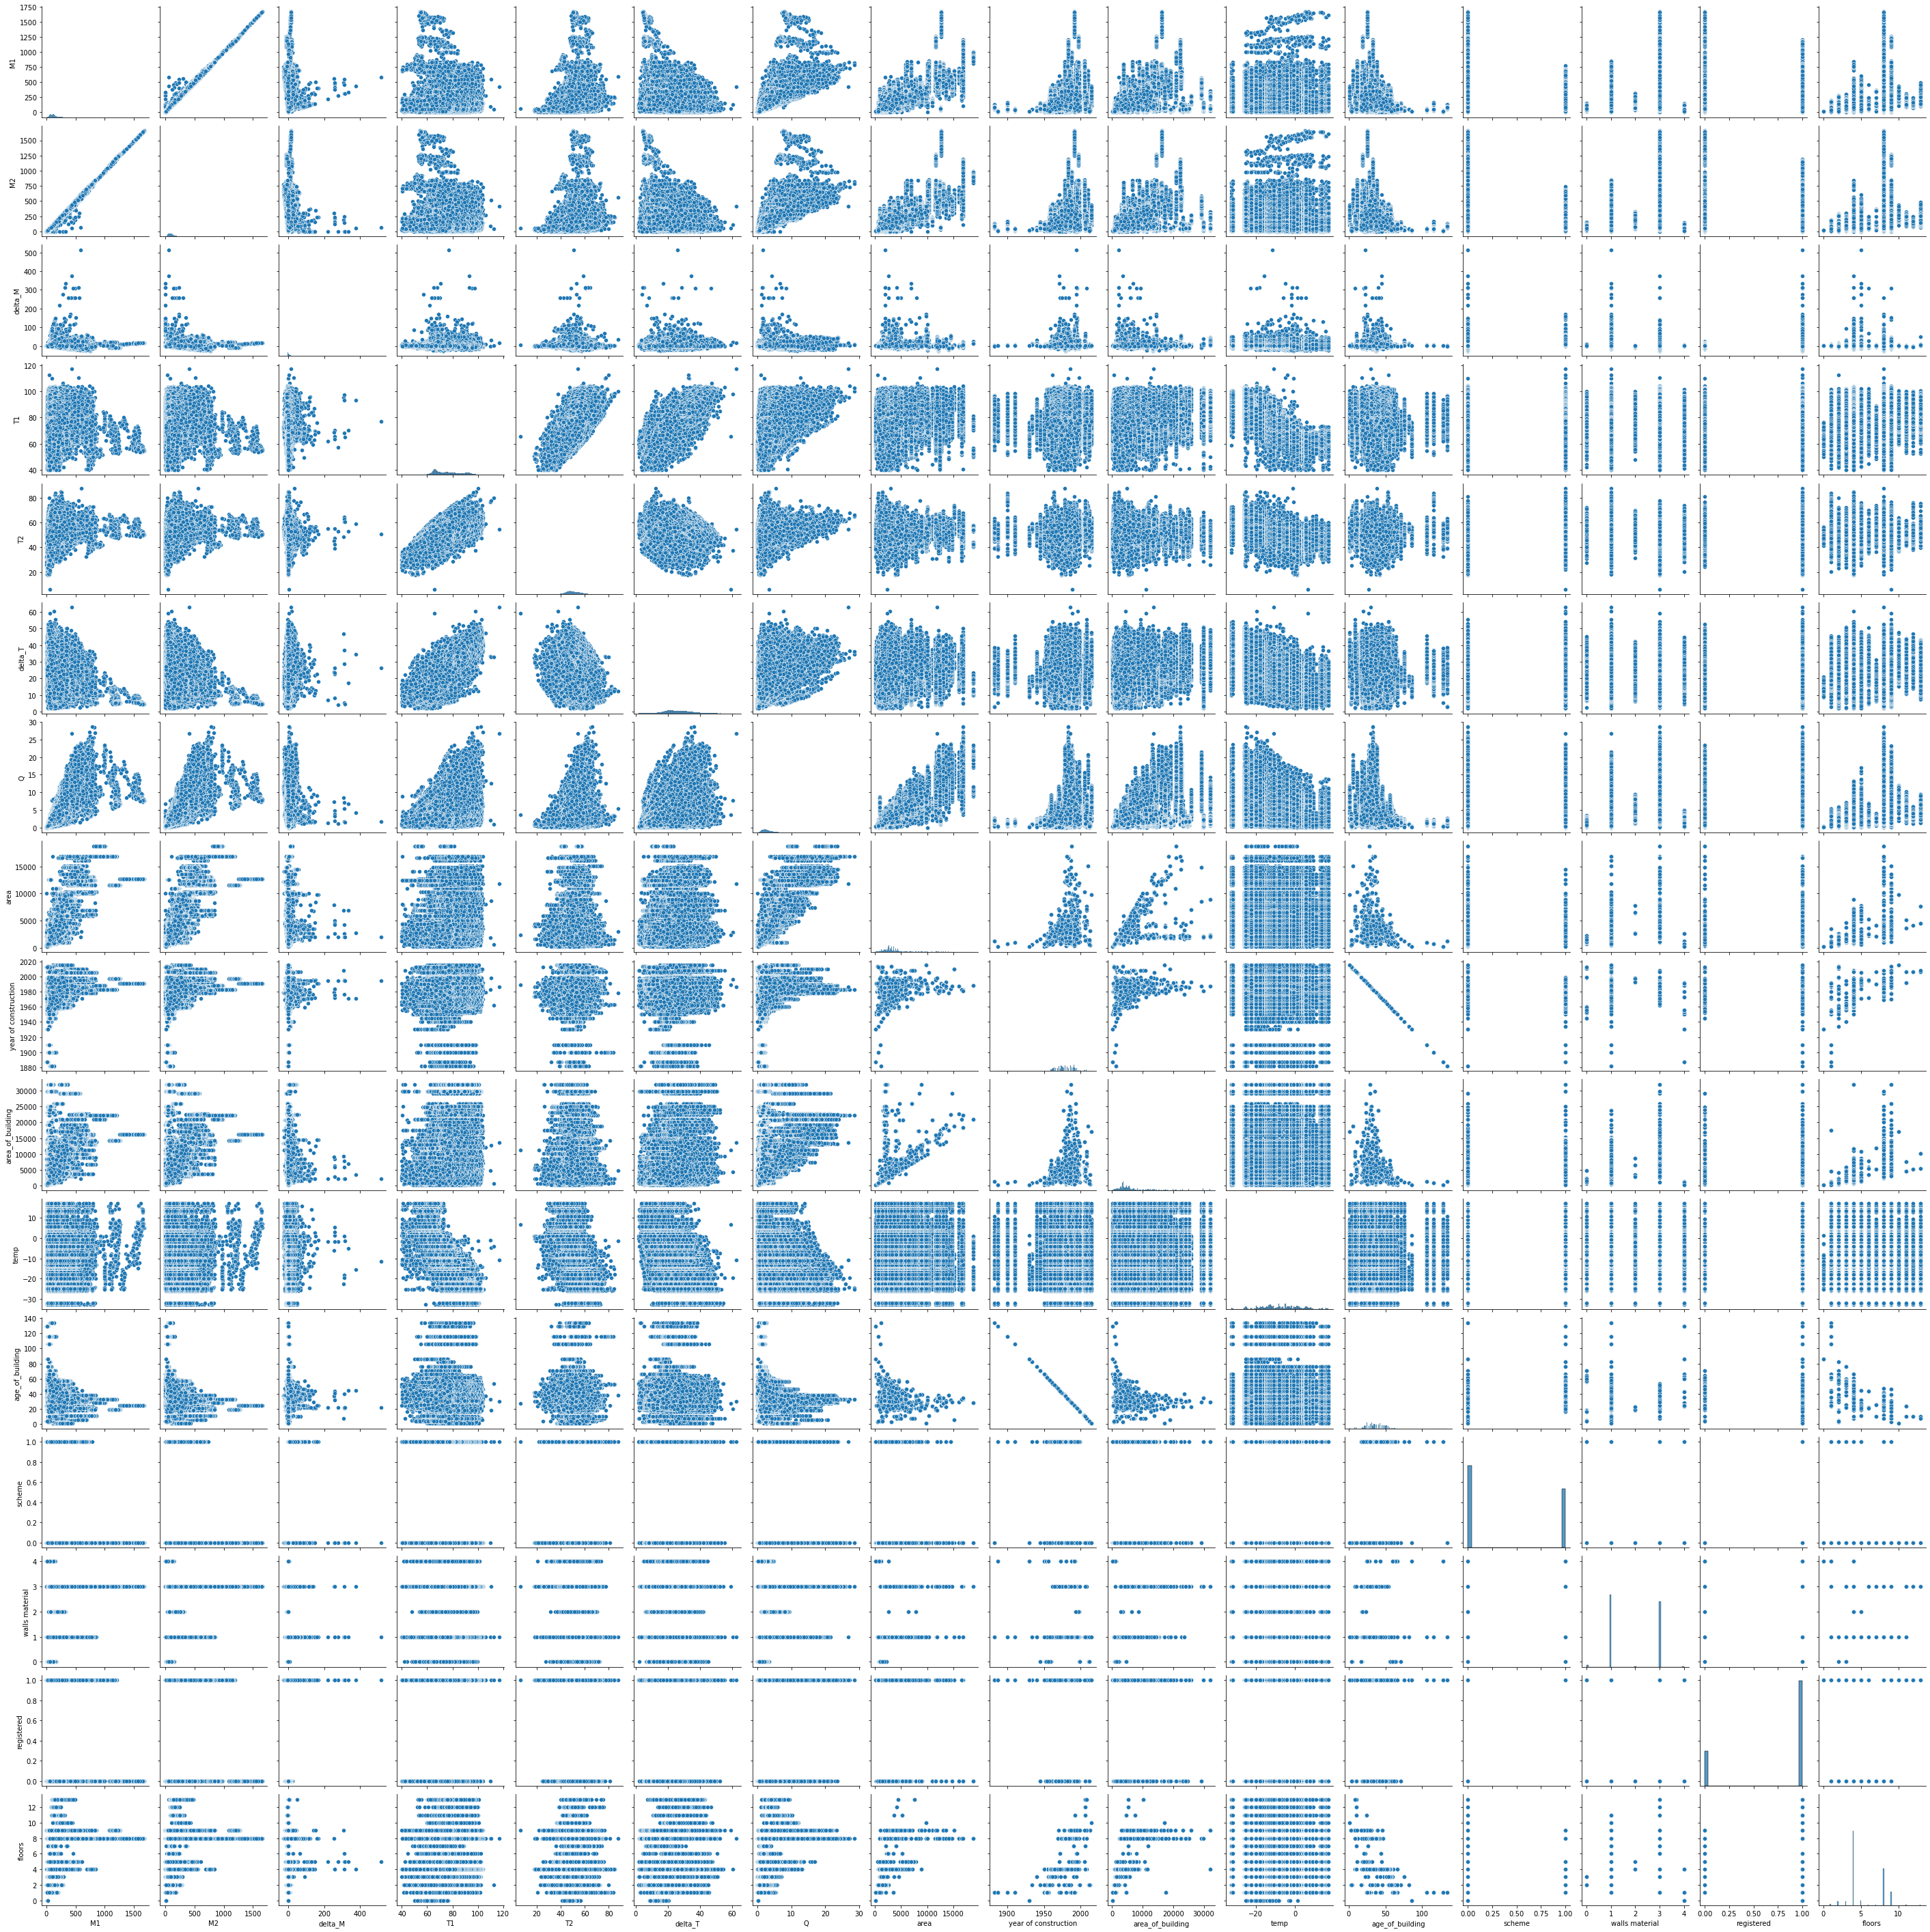

In [67]:
sns.pairplot(data=data_Label)
plt.show()

In [68]:
data_Label.describe()

M1             M2        delta_M             T1  \
count  164792.000000  164792.000000  164792.000000  164792.000000   
mean      137.630041     133.575492       4.054543      76.274687   
std       111.781591     111.300147       7.543280      11.042464   
min         0.800000       0.010000     -25.600000      40.010000   
25%        75.080000      71.470000      -0.190000      66.880000   
50%       113.040000     107.590000       2.000000      74.900000   
75%       157.250000     152.680000       7.000000      85.220000   
max      1675.390000    1659.390000     514.310000     116.990000   

                  T2        delta_T              Q           area  \
count  164792.000000  164792.000000  164792.000000  164792.000000   
mean       50.367019      25.907669       3.385007    3476.709410   
std         5.812095       8.006409       2.535829    2268.625664   
min         6.380000       2.050000       0.010000     169.400000   
25%        46.310000      20.310000       1.880000    2143.700000   
50%        49.760000      25.470000       2.760000    2943.700000   
75%        54.260000      31.590000       4.040000    3964.800000   
max        87.510000      62.710000      28.670000   18801.100000   

       year of construction  area_of_building           temp  age_of_building  \
count         164792.000000     164792.000000  164792.000000    164792.000000   
mean            1978.648545       7066.471478      -7.304365        37.351455   
std               12.598548       6322.387367      10.247033        12.598548   
min             1882.000000        169.400000     -32.582617         1.000000   
25%             1970.000000       3418.500000     -14.349412        29.000000   
50%             1979.000000       4767.000000      -7.930418        37.000000   
75%             1987.000000       7943.900000       0.582159        46.000000   
max             2015.000000      32030.920000      16.963864       134.000000   

              scheme  walls material     registered         floors  
count  164792.000000   164792.000000  164792.000000  164792.000000  
mean        0.417247        1.942855       0.749757       5.499472  
std         0.493106        1.023357       0.433154       2.250684  
min         0.000000        0.000000       0.000000       0.000000  
25%         0.000000        1.000000       0.000000       4.000000  
50%         0.000000        1.000000       1.000000       4.000000  
75%         1.000000        3.000000       1.000000       8.000000  
max         1.000000        4.000000       1.000000      13.000000

In [69]:
data_Label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164792 entries, 0 to 164791
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   M1                    164792 non-null  float64
 1   M2                    164792 non-null  float64
 2   delta_M               164792 non-null  float64
 3   T1                    164792 non-null  float64
 4   T2                    164792 non-null  float64
 5   delta_T               164792 non-null  float64
 6   Q                     164792 non-null  float64
 7   area                  164792 non-null  float64
 8   year of construction  164792 non-null  int64  
 9   area_of_building      164792 non-null  float64
 10  temp                  164792 non-null  float64
 11  level                 164792 non-null  object 
 12  age_of_building       164792 non-null  int64  
 13  scheme                164792 non-null  int64  
 14  walls material        164792 non-null  int64  
 15  

In [70]:
data_Label['if_water'] = data_Label['registered'].apply(lambda x: True if x==1 else False)
data_Label['level_High']= data_Label['level'].astype(float, errors = 'raise').apply(lambda x: True if x>3.5 else False)
data_Label

M1      M2  delta_M     T1     T2  delta_T     Q    area  \
0       102.51   92.05    10.46  81.99  53.36    28.63  2.94  2707.4   
1       124.86  125.29    -0.43  82.58  50.24    32.34  4.05  3358.4   
2       127.31  128.51    -1.20  83.26  51.72    31.55  4.02  3153.5   
3        86.36   81.61     4.75  92.55  54.82    37.73  3.26  2646.5   
4       170.81  168.74     2.07  83.29  59.70    23.59  4.04  3187.5   
...        ...     ...      ...    ...    ...      ...   ...     ...   
164787  102.46   86.99    15.47  77.50  52.95    24.55  2.51  1886.0   
164788   79.47   71.58     7.89  77.56  48.82    28.74  2.29  2139.1   
164789  274.49  272.79     1.69  77.89  49.34    28.55  7.86  6609.2   
164790  436.13  437.33    -1.20  66.52  49.35    17.17  7.50  6447.4   
164791  222.53  220.91     1.62  66.48  49.73    16.75  3.73  4098.4   

        year of construction  area_of_building       temp level  \
0                       1983           4401.00 -17.782121     1   
1                       1974           3610.40 -17.782121     1   
2                       1975           3150.20 -17.782121     1   
3                       1982           2932.70 -17.782121     1   
4                       1976           3456.20 -17.782121     1   
...                      ...               ...        ...   ...   
164787                  1979          13548.30  -8.144842     1   
164788                  1964           4262.06  -8.144842     1   
164789                  1999          12626.10  -8.144842     2   
164790                  1988           7249.70  -8.144842     2   
164791                  1982           4484.20  -8.144842     1   

        age_of_building  scheme  walls material  registered  floors  if_water  \
0                    33       1               3           1       4      True   
1                    42       0               1           1       4      True   
2                    41       0               1           1       4      True   
3                    34       1               3           1       4      True   
4                    40       0               1           1       4      True   
...                 ...     ...             ...         ...     ...       ...   
164787               37       1               3           1       8      True   
164788               52       1               3           1       4      True   
164789               17       0               3           1       9      True   
164790               28       0               1           1       4      True   
164791               34       0               1           0       4     False   

        level_High  
0            False  
1            False  
2            False  
3            False  
4            False  
...            ...  
164787       False  
164788       False  
164789       False  
164790       False  
164791       False  

[164792 rows x 19 columns]

In [71]:
training = data_Label[['M1', 'M2', 'delta_M', 'T1', 'T2', 'delta_T','area', 'area_of_building', 'temp', 'if_water', 'level_High']].copy()

# Causal Inference 因果推断


model: modelling causal inference problems using hypotheses (a priori knowledge) 

identify: identifying expressions (causal estimates) of causal effects under assumptions (models)

estimate: estimation of expressions using statistical methods

refute: using various robustness checks to verify the correctness of estimates

「建模」（model）：利用假设（先验知识）对因果推断问题建模 

「识别」（identify）：在假设（模型）下识别因果效应的表达式（因果估计量）

「估计」（estimate）：使用统计方法对表达式进行估计

「反驳」（refute）：使用各种鲁棒性检查来验证估计的正确性


## Would registered affecting the consumption?

### Building a causal model
Domain knowledge is encoded into a causal model, usually represented as a diagram. The final result of a causal inference analysis depends heavily on the input assumptions, so this step is quite important. In order to estimate causal effects, most common problems involve specifying two types of variables.

Confounding factors. These are variables that cause both the action and the outcome. Thus, any observed correlation between action and outcome may be due to confounding variables alone, rather than to any causal relationship from action to outcome.

Instrumental variables. These are specific variables that lead to actions, but do not directly affect outcomes. Furthermore, they are not influenced by any of the variables that affect the outcome. When used in the right way, instrumental variables can help reduce bias.

In [72]:
#Creating the 
causal_graph = """
digraph {
M1;
M2;
delta_M;
T1;
T2;
delta_T;
area;
area_of_building;
temp;
if_water;
level_High;
U[label="Unobserved Confounders"];
M1 -> delta_M; M2 -> delta_M; T1 -> delta_T; T2 -> delta_T; delta_M -> level_High; delta_T -> level_High; area -> level_High; area_of_building -> level_High;
temp -> level_High; if_water -> level_High;
U -> level_High; U -> temp; U ->if_water;
}
"""

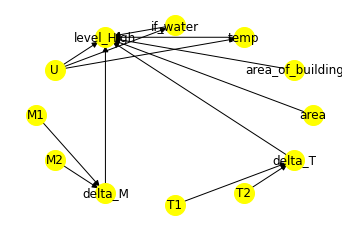

In [84]:
from dowhy import CausalModel
from IPython.display import Image, display
model= CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment='if_water',
        outcome='level_High')
model.view_model()

### Identify the causal effect
Causal Analysis states that the Treatment affecting the Outcome if changing the treatment affects the Outcome when everything else is still the same (constant)

In [76]:

estimands = model.identify_effect(proceed_when_unidentifiable=True)
print(estimands)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
───────────(Expectation(level_High|T1,delta_T,M1,area_of_building,T2,M2,delta_
d[if_water]                                                                   

             
M,temp,area))
             
Estimand assumption 1, Unconfoundedness: If U→{if_water} and U→level_High then P(level_High|if_water,T1,delta_T,M1,area_of_building,T2,M2,delta_M,temp,area,U) = P(level_High|if_water,T1,delta_T,M1,area_of_building,T2,M2,delta_M,temp,area)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



### Causal Effect Estimation
The causal effect of treatment on outcomes is based on changes in the values of treatment variables. How strong the effect is is a matter of statistical estimation.

In [77]:

estimate = model.estimate_effect(estimands,method_name = "backdoor.propensity_score_weighting")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
───────────(Expectation(level_High|T1,delta_T,M1,area_of_building,T2,M2,delta_
d[if_water]                                                                   

             
M,temp,area))
             
Estimand assumption 1, Unconfoundedness: If U→{if_water} and U→level_High then P(level_High|if_water,T1,delta_T,M1,area_of_building,T2,M2,delta_M,temp,area,U) = P(level_High|if_water,T1,delta_T,M1,area_of_building,T2,M2,delta_M,temp,area)

## Realized estimand
b: level_High~if_water+T1+delta_T+M1+area_of_building+T2+M2+delta_M+temp+area
Target units: ate

## Estimate
Mean value: 0.0015697962139170647



### Refute the obtained Estimate 
Refutation of the estimates obtained (random covariates - an independent random variable is added to the data set as a covariate; if the hypothesis is correct, the estimates should not change.)

Estimates of causal effects are statistical estimates based on the data, but the causality itself is not based on the data; it is based on our previous assumptions.

In [78]:
refutel = model.refute_estimate(estimands,estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:0.0015697962139170647
New effect:0.0015697506959323898



### Data Subset Refuter 

Replaces a given data set with a randomly selected subset; if the assumptions are correct, the estimates should not change much.

In [79]:
refutel = model.refute_estimate(estimands,estimate, "data_subset_refuter")
print(refutel)

/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Refute: Use a subset of data
Estimated effect:0.0015697962139170647
New effect:0.0014945558501574974
p value:0.49



/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Placebo Treatment
Replace the true treatment variable with an independent random variable; if the assumption is correct, the estimate should be close to zero

In [83]:
refutel = model.refute_estimate(estimands,estimate, "placebo_treatment_refuter")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:0.0015697962139170647
New effect:6.317047496093037e-06
p value:0.45



## Would delta M affecting the consumption? 

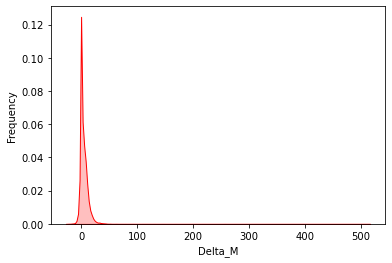

In [86]:
h = sns.kdeplot(training['delta_M'], color="Red", shade = True)
h.set_xlabel("Delta_M")
h.set_ylabel("Frequency")
plt.show()

In [87]:
training['delta_M'].describe()

count    164792.000000
mean          4.054543
std           7.543280
min         -25.600000
25%          -0.190000
50%           2.000000
75%           7.000000
max         514.310000
Name: delta_M, dtype: float64

In [110]:
training = data_Label[['M1', 'M2', 'delta_M', 'T1', 'T2', 'delta_T','area', 'area_of_building', 'temp','registered', 'level_High']].copy()
training['delta_M_high']= data_Label['delta_M'].astype(float, errors = 'raise').apply(lambda x: True if x>2 else False)


In [111]:
training

M1      M2  delta_M     T1     T2  delta_T    area  \
0       102.51   92.05    10.46  81.99  53.36    28.63  2707.4   
1       124.86  125.29    -0.43  82.58  50.24    32.34  3358.4   
2       127.31  128.51    -1.20  83.26  51.72    31.55  3153.5   
3        86.36   81.61     4.75  92.55  54.82    37.73  2646.5   
4       170.81  168.74     2.07  83.29  59.70    23.59  3187.5   
...        ...     ...      ...    ...    ...      ...     ...   
164787  102.46   86.99    15.47  77.50  52.95    24.55  1886.0   
164788   79.47   71.58     7.89  77.56  48.82    28.74  2139.1   
164789  274.49  272.79     1.69  77.89  49.34    28.55  6609.2   
164790  436.13  437.33    -1.20  66.52  49.35    17.17  6447.4   
164791  222.53  220.91     1.62  66.48  49.73    16.75  4098.4   

        area_of_building       temp  registered  level_High  delta_M_high  
0                4401.00 -17.782121           1       False          True  
1                3610.40 -17.782121           1       False         False  
2                3150.20 -17.782121           1       False         False  
3                2932.70 -17.782121           1       False          True  
4                3456.20 -17.782121           1       False          True  
...                  ...        ...         ...         ...           ...  
164787          13548.30  -8.144842           1       False          True  
164788           4262.06  -8.144842           1       False          True  
164789          12626.10  -8.144842           1       False         False  
164790           7249.70  -8.144842           1       False         False  
164791           4484.20  -8.144842           0       False         False  

[164792 rows x 12 columns]

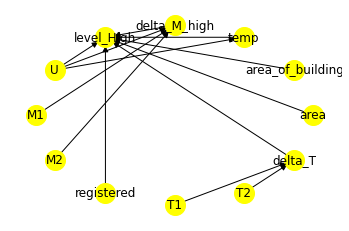

In [112]:
#Creating the 
causal_graph = """
digraph {
M1;
M2;
registered;
T1;
T2;
delta_T;
area;
area_of_building;
temp;
delta_M_high;
level_High;
U[label="c"];
M1 -> delta_M_high; M2 -> delta_M_high; 
T1 -> delta_T; T2 -> delta_T; 
delta_T -> level_High; area -> level_High; area_of_building -> level_High;
temp -> level_High; delta_M_high -> level_High;
U -> level_High; U ->delta_M_high; U -> temp;
registered ->level_High;
}
"""

from dowhy import CausalModel
from IPython.display import Image, display
model= CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment='delta_M_high',
        outcome='level_High')
model.view_model()

### 定义因果效应
Causal Analysis states that the Treatment affecting the Outcome if changing the treatment affects the Outcome when everything else is still the same (constant)

In [113]:
#Identify the causal effect
estimands = model.identify_effect(proceed_when_unidentifiable=True)
print(estimands)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
───────────(Expectation(level_High|T1,registered,delta_T,area_of_building,T2,t
d[δ_M_high]                                                                   

          
emp,area))
          
Estimand assumption 1, Unconfoundedness: If U→{delta_M_high} and U→level_High then P(level_High|delta_M_high,T1,registered,delta_T,area_of_building,T2,temp,area,U) = P(level_High|delta_M_high,T1,registered,delta_T,area_of_building,T2,temp,area)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(level_High, [M1, M2])*Derivative([delta_M_high], [M1, M
2])**(-1))
Estimand assumption 1, As-if-random: If U→→level_High then ¬(U →→{M1,M2})
Estimand assumption 2, Exclusion: If we remove {M1,M2}→{delta_M_high}, then ¬({M1,M2}→level_High)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



### 根据统计方法估计因果效应
治疗对结果的因果效应是基于治疗变量值的变化。效果有多强是一个统计估计的问题。

In [114]:
#Causal Effect Estimation
estimate = model.estimate_effect(estimands,method_name = "backdoor.propensity_score_weighting")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
───────────(Expectation(level_High|T1,registered,delta_T,area_of_building,T2,t
d[δ_M_high]                                                                   

          
emp,area))
          
Estimand assumption 1, Unconfoundedness: If U→{delta_M_high} and U→level_High then P(level_High|delta_M_high,T1,registered,delta_T,area_of_building,T2,temp,area,U) = P(level_High|delta_M_high,T1,registered,delta_T,area_of_building,T2,temp,area)

## Realized estimand
b: level_High~delta_M_high+T1+registered+delta_T+area_of_building+T2+temp+area
Target units: ate

## Estimate
Mean value: 0.0038847056229591014



### Refute the obtained Estimate 
反驳获得的估计结果（随机共因--在数据集中添加一个独立的随机变量作为共因；如果假设正确，估计结果不应改变。）
因果效应的估计是基于数据的统计估计，但因果关系本身不是基于数据；而是基于我们之前的假设。

In [115]:
refutel = model.refute_estimate(estimands,estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:0.0038847056229591014
New effect:0.0038641267395337882



### 数据子集Refuter - 用一个随机选择的子集替换给定的数据集；如果假设正确，估计值不应该有太大的变化。

In [116]:
refutel = model.refute_estimate(estimands,estimate, "data_subset_refuter")
print(refutel)

/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Refute: Use a subset of data
Estimated effect:0.0038847056229591014
New effect:0.0038018842896062077
p value:0.49



### Placebo Treatment 安慰剂
用一个独立的随机变量取代真正的治疗变量；如果假设正确，估计值应该接近于零。

In [117]:
refutel = model.refute_estimate(estimands,estimate, "placebo_treatment_refuter")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:0.0038847056229591014
New effect:1.3821457601528856e-05
p value:0.46



## Would M1 affecting the consumption?

In [120]:
training['M1'].describe()

count    164792.000000
mean        137.630041
std         111.781591
min           0.800000
25%          75.080000
50%         113.040000
75%         157.250000
max        1675.390000
Name: M1, dtype: float64

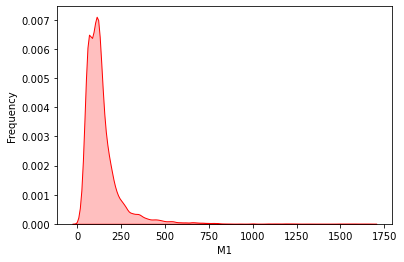

In [121]:
h = sns.kdeplot(training['M1'], color="Red", shade = True)
h.set_xlabel("M1")
h.set_ylabel("Frequency")
plt.show()

In [124]:
training = data_Label[['M1', 'M2', 'delta_M', 'T1', 'T2', 'delta_T','area', 'area_of_building', 'temp','registered', 'level_High']].copy()
training['M1_high']= data_Label['M1'].astype(float, errors = 'raise').apply(lambda x: True if x>137 else False)
training.head(10)

M1      M2  delta_M     T1     T2  delta_T      area  \
0   102.51   92.05    10.46  81.99  53.36    28.63   2707.40   
1   124.86  125.29    -0.43  82.58  50.24    32.34   3358.40   
2   127.31  128.51    -1.20  83.26  51.72    31.55   3153.50   
3    86.36   81.61     4.75  92.55  54.82    37.73   2646.50   
4   170.81  168.74     2.07  83.29  59.70    23.59   3187.50   
5  1004.90  982.48    22.42  76.07  55.98    20.09  18801.10   
6   120.56  105.68    14.87  80.64  51.62    29.01   3604.55   
7    98.13   88.30     9.82  82.99  49.18    33.80   3234.45   
8    97.25   80.42    16.83  84.09  52.14    31.96   2509.35   
9   158.92  161.78    -2.86  81.25  55.04    26.21   3574.70   

   area_of_building       temp  registered  level_High  M1_high  
0           4401.00 -17.782121           1       False    False  
1           3610.40 -17.782121           1       False    False  
2           3150.20 -17.782121           1       False    False  
3           2932.70 -17.782121           1       False    False  
4           3456.20 -17.782121           1       False     True  
5          21000.00 -17.782121           0        True     True  
6           4779.29 -17.782121           1       False    False  
7           4319.65 -17.782121           1       False    False  
8           3382.25 -17.782121           1       False    False  
9           5138.10 -17.782121           1       False     True

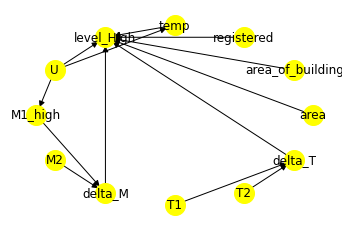

In [126]:
#Creating the 
causal_graph = """
digraph {
M1_high;
M2;
delta_M;
T1;
T2;
delta_T;
area;
area_of_building;
registered;
temp;
level_High;
U[label="Unobserved Confounders"];
M1_high -> delta_M; M2 -> delta_M; 
T1 -> delta_T; T2 -> delta_T; 
delta_T -> level_High; area -> level_High; area_of_building -> level_High;
temp -> level_High; delta_M -> level_High;
U -> level_High; U -> temp;
registered ->level_High;
U -> M1_high;
}
"""

from dowhy import CausalModel
from IPython.display import Image, display
model= CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment='M1_high',
        outcome='level_High')
model.view_model()




In [127]:
#Identify the causal effect
estimands = model.identify_effect(proceed_when_unidentifiable=True)
print(estimands)



Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
───────────(Expectation(level_High|T1,registered,delta_T,area_of_building,T2,M
d[M_1_high]                                                                   

             
2,temp,area))
             
Estimand assumption 1, Unconfoundedness: If U→{M1_high} and U→level_High then P(level_High|M1_high,T1,registered,delta_T,area_of_building,T2,M2,temp,area,U) = P(level_High|M1_high,T1,registered,delta_T,area_of_building,T2,M2,temp,area)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
Expectation(Derivative(level_High, [delta_M])*Derivative([delta_M], [M1_high])
)
Estimand assumption 1, Full-mediation: delta_M intercepts (blocks) all directed paths from M1_high to l,e,v,e,l,_,H,i,g,h.
Estimand assumption 2, First-stage-unconfoundedness: If U→{M

In [128]:
#Causal Effect Estimation
estimate = model.estimate_effect(estimands,method_name = "backdoor.propensity_score_weighting")
print(estimate)



*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
───────────(Expectation(level_High|T1,registered,delta_T,area_of_building,T2,M
d[M_1_high]                                                                   

             
2,temp,area))
             
Estimand assumption 1, Unconfoundedness: If U→{M1_high} and U→level_High then P(level_High|M1_high,T1,registered,delta_T,area_of_building,T2,M2,temp,area,U) = P(level_High|M1_high,T1,registered,delta_T,area_of_building,T2,M2,temp,area)

## Realized estimand
b: level_High~M1_high+T1+registered+delta_T+area_of_building+T2+M2+temp+area
Target units: ate

## Estimate
Mean value: 0.008125075054742054



In [129]:
refutel = model.refute_estimate(estimands,estimate, "random_common_cause")
print(refutel)



Refute: Add a Random Common Cause
Estimated effect:0.008125075054742054
New effect:0.008125075054742054



/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [130]:
refutel = model.refute_estimate(estimands,estimate, "data_subset_refuter")
print(refutel)

/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Refute: Use a subset of data
Estimated effect:0.008125075054742054
New effect:0.008117944177007288
p value:0.4



In [131]:
refutel = model.refute_estimate(estimands,estimate, "placebo_treatment_refuter")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:0.008125075054742054
New effect:-2.4877575636192513e-05
p value:0.5



## Would M2 effecting consumption?

In [147]:
training = data_Label[['M1', 'M2', 'delta_M', 'T1', 'T2', 'delta_T','area', 'area_of_building', 'temp','registered', 'level_High']].copy()
training['M2_high']= data_Label['M2'].astype(float, errors = 'raise').apply(lambda x: True if x>133.6 else False)
training.describe()

M1             M2        delta_M             T1  \
count  164792.000000  164792.000000  164792.000000  164792.000000   
mean      137.630041     133.575492       4.054543      76.274687   
std       111.781591     111.300147       7.543280      11.042464   
min         0.800000       0.010000     -25.600000      40.010000   
25%        75.080000      71.470000      -0.190000      66.880000   
50%       113.040000     107.590000       2.000000      74.900000   
75%       157.250000     152.680000       7.000000      85.220000   
max      1675.390000    1659.390000     514.310000     116.990000   

                  T2        delta_T           area  area_of_building  \
count  164792.000000  164792.000000  164792.000000     164792.000000   
mean       50.367019      25.907669    3476.709410       7066.471478   
std         5.812095       8.006409    2268.625664       6322.387367   
min         6.380000       2.050000     169.400000        169.400000   
25%        46.310000      20.310000    2143.700000       3418.500000   
50%        49.760000      25.470000    2943.700000       4767.000000   
75%        54.260000      31.590000    3964.800000       7943.900000   
max        87.510000      62.710000   18801.100000      32030.920000   

                temp     registered  
count  164792.000000  164792.000000  
mean       -7.304365       0.749757  
std        10.247033       0.433154  
min       -32.582617       0.000000  
25%       -14.349412       0.000000  
50%        -7.930418       1.000000  
75%         0.582159       1.000000  
max        16.963864       1.000000

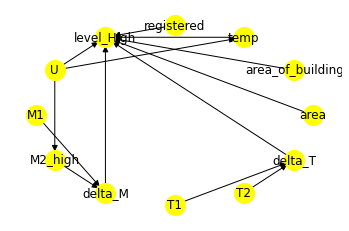

In [148]:
#Creating the 
causal_graph = """
digraph {
M1;
M2_high;
delta_M;
T1;
T2;
delta_T;
area;
area_of_building;
temp;
registered;
level_High;
U[label="Unobserved Confounders"];
M1 -> delta_M; M2_high -> delta_M; 
T1 -> delta_T; T2 -> delta_T; 
delta_T -> level_High; area -> level_High; area_of_building -> level_High;
temp -> level_High; delta_M -> level_High;
U -> level_High; U -> M2_high; U -> temp;
registered -> level_High;
}
"""

from dowhy import CausalModel
from IPython.display import Image, display
model= CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment='M2_high',
        outcome='level_High')
model.view_model()



In [149]:
#Identify the causal effect
estimands = model.identify_effect(proceed_when_unidentifiable=True)
print(estimands)



Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
───────────(Expectation(level_High|T1,registered,delta_T,M1,area_of_building,T
d[M_2_high]                                                                   

             
2,temp,area))
             
Estimand assumption 1, Unconfoundedness: If U→{M2_high} and U→level_High then P(level_High|M2_high,T1,registered,delta_T,M1,area_of_building,T2,temp,area,U) = P(level_High|M2_high,T1,registered,delta_T,M1,area_of_building,T2,temp,area)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
Expectation(Derivative(level_High, [delta_M])*Derivative([delta_M], [M2_high])
)
Estimand assumption 1, Full-mediation: delta_M intercepts (blocks) all directed paths from M2_high to l,e,v,e,l,_,H,i,g,h.
Estimand assumption 2, First-stage-unconfoundedness: If U→{M

In [150]:
#Causal Effect Estimation
estimate = model.estimate_effect(estimands,method_name = "backdoor.propensity_score_weighting")
print(estimate)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
───────────(Expectation(level_High|T1,registered,delta_T,M1,area_of_building,T
d[M_2_high]                                                                   

             
2,temp,area))
             
Estimand assumption 1, Unconfoundedness: If U→{M2_high} and U→level_High then P(level_High|M2_high,T1,registered,delta_T,M1,area_of_building,T2,temp,area,U) = P(level_High|M2_high,T1,registered,delta_T,M1,area_of_building,T2,temp,area)

## Realized estimand
b: level_High~M2_high+T1+registered+delta_T+M1+area_of_building+T2+temp+area
Target units: ate

## Estimate
Mean value: 0.008125075054742054



/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [151]:

refutel_random = model.refute_estimate(estimands,estimate, "random_common_cause")
print("refutel_random:" ,refutel_random)

refutel_subset = model.refute_estimate(estimands,estimate, "data_subset_refuter")
print("refutel_subset:" ,refutel_subset)

refutel_placebo = model.refute_estimate(estimands,estimate, "placebo_treatment_refuter")
print("refutel_placebo:" ,refutel_placebo)

/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


refutel_random: Refute: Add a Random Common Cause
Estimated effect:0.008125075054742054
New effect:0.008125075054742054



/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

refutel_subset: Refute: Use a subset of data
Estimated effect:0.008125075054742054
New effect:0.008116986034271169
p value:0.45999999999999996

refutel_placebo: Refute: Use a Placebo Treatment
Estimated effect:0.008125075054742054
New effect:2.796361962683986e-05
p value:0.46



## Would delta_T affecting the consumption?

In [153]:
training = data_Label[['M1', 'M2', 'delta_M', 'T1', 'T2', 'delta_T','area', 'area_of_building', 'temp','registered', 'level_High']].copy()
training['delta_T_high']= data_Label['delta_T'].astype(float, errors = 'raise').apply(lambda x: True if x>25.9 else False)
training.describe()

M1             M2        delta_M             T1  \
count  164792.000000  164792.000000  164792.000000  164792.000000   
mean      137.630041     133.575492       4.054543      76.274687   
std       111.781591     111.300147       7.543280      11.042464   
min         0.800000       0.010000     -25.600000      40.010000   
25%        75.080000      71.470000      -0.190000      66.880000   
50%       113.040000     107.590000       2.000000      74.900000   
75%       157.250000     152.680000       7.000000      85.220000   
max      1675.390000    1659.390000     514.310000     116.990000   

                  T2        delta_T           area  area_of_building  \
count  164792.000000  164792.000000  164792.000000     164792.000000   
mean       50.367019      25.907669    3476.709410       7066.471478   
std         5.812095       8.006409    2268.625664       6322.387367   
min         6.380000       2.050000     169.400000        169.400000   
25%        46.310000      20.310000    2143.700000       3418.500000   
50%        49.760000      25.470000    2943.700000       4767.000000   
75%        54.260000      31.590000    3964.800000       7943.900000   
max        87.510000      62.710000   18801.100000      32030.920000   

                temp     registered  
count  164792.000000  164792.000000  
mean       -7.304365       0.749757  
std        10.247033       0.433154  
min       -32.582617       0.000000  
25%       -14.349412       0.000000  
50%        -7.930418       1.000000  
75%         0.582159       1.000000  
max        16.963864       1.000000

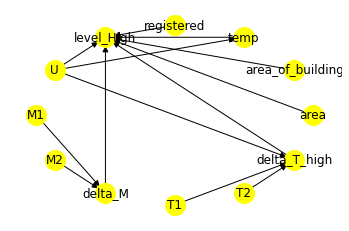

In [154]:
#Creating the 
causal_graph = """
digraph {
M1;
M2;
delta_M;
T1;
T2;
delta_T_high;
area;
area_of_building;
temp;
registered;
level_High;
U[label="Unobserved Confounders"];
M1 -> delta_M; M2 -> delta_M; 
T1 -> delta_T_high; T2 -> delta_T_high; 
delta_T_high -> level_High; area -> level_High; area_of_building -> level_High;
temp -> level_High; delta_M -> level_High;
U -> level_High; U -> delta_T_high; U -> temp;
registered -> level_High;
}
"""

from dowhy import CausalModel
from IPython.display import Image, display
model= CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment='delta_T_high',
        outcome='level_High')
model.view_model()



In [155]:
#Identify the causal effect
estimands = model.identify_effect(proceed_when_unidentifiable=True)
print(estimands)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
───────────(Expectation(level_High|registered,M1,area_of_building,M2,delta_M,t
d[δ_T_high]                                                                   

          
emp,area))
          
Estimand assumption 1, Unconfoundedness: If U→{delta_T_high} and U→level_High then P(level_High|delta_T_high,registered,M1,area_of_building,M2,delta_M,temp,area,U) = P(level_High|delta_T_high,registered,M1,area_of_building,M2,delta_M,temp,area)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(level_High, [T1, T2])*Derivative([delta_T_high], [T1, T
2])**(-1))
Estimand assumption 1, As-if-random: If U→→level_High then ¬(U →→{T1,T2})
Estimand assumption 2, Exclusion: If we remove {T1,T2}→{delta_T_high}, then ¬({T1,T2}→level_High)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [156]:
#Causal Effect Estimation
estimate = model.estimate_effect(estimands,method_name = "backdoor.propensity_score_weighting")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
───────────(Expectation(level_High|registered,M1,area_of_building,M2,delta_M,t
d[δ_T_high]                                                                   

          
emp,area))
          
Estimand assumption 1, Unconfoundedness: If U→{delta_T_high} and U→level_High then P(level_High|delta_T_high,registered,M1,area_of_building,M2,delta_M,temp,area,U) = P(level_High|delta_T_high,registered,M1,area_of_building,M2,delta_M,temp,area)

## Realized estimand
b: level_High~delta_T_high+registered+M1+area_of_building+M2+delta_M+temp+area
Target units: ate

## Estimate
Mean value: 0.017690791542126463



/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [157]:
refutel_random = model.refute_estimate(estimands,estimate, "random_common_cause")
print("refutel_random:" ,refutel_random)

refutel_subset = model.refute_estimate(estimands,estimate, "data_subset_refuter")
print("refutel_subset:" ,refutel_subset)

refutel_placebo = model.refute_estimate(estimands,estimate, "placebo_treatment_refuter")
print("refutel_placebo:" ,refutel_placebo)

/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


refutel_random: Refute: Add a Random Common Cause
Estimated effect:0.017690791542126463
New effect:0.02575347871317195



/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

refutel_subset: Refute: Use a subset of data
Estimated effect:0.017690791542126463
New effect:0.02162831782747889
p value:0.04

refutel_placebo: Refute: Use a Placebo Treatment
Estimated effect:0.017690791542126463
New effect:9.078518204368589e-05
p value:0.42



## Would temp effecting the consumption?

In [160]:
training = data_Label[['M1', 'M2', 'delta_M', 'T1', 'T2', 'delta_T','area', 'area_of_building', 'temp','registered', 'level_High']].copy()
training['temp_high']= data_Label['temp'].astype(float, errors = 'raise').apply(lambda x: True if x>-7.3 else False)
training.head()

M1      M2  delta_M     T1     T2  delta_T    area  area_of_building  \
0  102.51   92.05    10.46  81.99  53.36    28.63  2707.4            4401.0   
1  124.86  125.29    -0.43  82.58  50.24    32.34  3358.4            3610.4   
2  127.31  128.51    -1.20  83.26  51.72    31.55  3153.5            3150.2   
3   86.36   81.61     4.75  92.55  54.82    37.73  2646.5            2932.7   
4  170.81  168.74     2.07  83.29  59.70    23.59  3187.5            3456.2   

        temp  registered  level_High  temp_high  
0 -17.782121           1       False      False  
1 -17.782121           1       False      False  
2 -17.782121           1       False      False  
3 -17.782121           1       False      False  
4 -17.782121           1       False      False

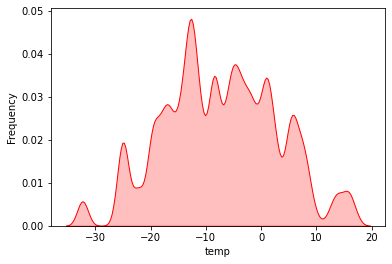

In [167]:
h = sns.kdeplot(training['temp'], color="Red", shade = True)
h.set_xlabel("temp")
h.set_ylabel("Frequency")
plt.show()

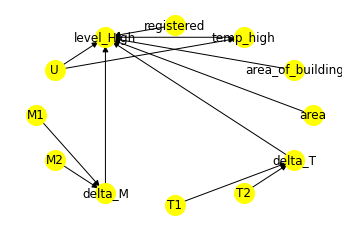

In [163]:
#Creating the 
causal_graph = """
digraph {
M1;
M2;
delta_M;
T1;
T2;
delta_T;
area;
area_of_building;
temp_high;
registered;
level_High;
U[label="Unobserved Confounders"];
M1 -> delta_M; M2 -> delta_M; 
T1 -> delta_T; T2 -> delta_T; 
delta_T -> level_High; area -> level_High; area_of_building -> level_High;
temp_high -> level_High; delta_M -> level_High; registered -> level_High;
U -> level_High; U -> temp_high;

}
"""

from dowhy import CausalModel
from IPython.display import Image, display
model= CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment='temp_high',
        outcome='level_High')
model.view_model()

In [164]:
#Identify the causal effect
estimands = model.identify_effect(proceed_when_unidentifiable=True)
print(estimands)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(level_High|T1,registered,delta_T,M1,area_of_building,
d[temp_high]                                                                  

                    
T2,M2,delta_M,area))
                    
Estimand assumption 1, Unconfoundedness: If U→{temp_high} and U→level_High then P(level_High|temp_high,T1,registered,delta_T,M1,area_of_building,T2,M2,delta_M,area,U) = P(level_High|temp_high,T1,registered,delta_T,M1,area_of_building,T2,M2,delta_M,area)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [165]:
#Causal Effect Estimation
estimate = model.estimate_effect(estimands,method_name = "backdoor.propensity_score_weighting")
print(estimate)



*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(level_High|T1,registered,delta_T,M1,area_of_building,
d[temp_high]                                                                  

                    
T2,M2,delta_M,area))
                    
Estimand assumption 1, Unconfoundedness: If U→{temp_high} and U→level_High then P(level_High|temp_high,T1,registered,delta_T,M1,area_of_building,T2,M2,delta_M,area,U) = P(level_High|temp_high,T1,registered,delta_T,M1,area_of_building,T2,M2,delta_M,area)

## Realized estimand
b: level_High~temp_high+T1+registered+delta_T+M1+area_of_building+T2+M2+delta_M+area
Target units: ate

## Estimate
Mean value: -0.017703673303839318



/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [166]:
refutel_random = model.refute_estimate(estimands,estimate, "random_common_cause")
print("refutel_random:" ,refutel_random)

refutel_subset = model.refute_estimate(estimands,estimate, "data_subset_refuter")
print("refutel_subset:" ,refutel_subset)

refutel_placebo = model.refute_estimate(estimands,estimate, "placebo_treatment_refuter")
print("refutel_placebo:" ,refutel_placebo)

/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


refutel_random: Refute: Add a Random Common Cause
Estimated effect:-0.017703673303839318
New effect:-0.008374323305393887



/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

refutel_subset: Refute: Use a subset of data
Estimated effect:-0.017703673303839318
New effect:-0.017957773519716887
p value:0.31000000000000005

refutel_placebo: Refute: Use a Placebo Treatment
Estimated effect:-0.017703673303839318
New effect:2.193669338293943e-05
p value:0.5



## area

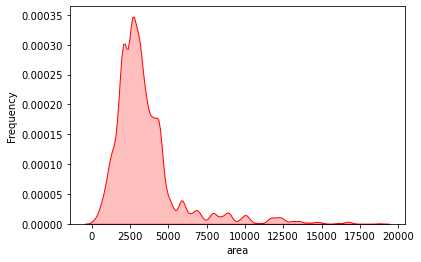

In [170]:
h = sns.kdeplot(training['area'], color="Red", shade = True)
h.set_xlabel("area")
h.set_ylabel("Frequency")
plt.show()

In [176]:
training = data_Label[['M1', 'M2', 'delta_M', 'T1', 'T2', 'delta_T','area', 'area_of_building', 'temp','registered', 'level_High']].copy()
training['area_high']= data_Label['area'].astype(float, errors = 'raise').apply(lambda x: True if x>2943.7 else False)
training.describe()

M1             M2        delta_M             T1  \
count  164792.000000  164792.000000  164792.000000  164792.000000   
mean      137.630041     133.575492       4.054543      76.274687   
std       111.781591     111.300147       7.543280      11.042464   
min         0.800000       0.010000     -25.600000      40.010000   
25%        75.080000      71.470000      -0.190000      66.880000   
50%       113.040000     107.590000       2.000000      74.900000   
75%       157.250000     152.680000       7.000000      85.220000   
max      1675.390000    1659.390000     514.310000     116.990000   

                  T2        delta_T           area  area_of_building  \
count  164792.000000  164792.000000  164792.000000     164792.000000   
mean       50.367019      25.907669    3476.709410       7066.471478   
std         5.812095       8.006409    2268.625664       6322.387367   
min         6.380000       2.050000     169.400000        169.400000   
25%        46.310000      20.310000    2143.700000       3418.500000   
50%        49.760000      25.470000    2943.700000       4767.000000   
75%        54.260000      31.590000    3964.800000       7943.900000   
max        87.510000      62.710000   18801.100000      32030.920000   

                temp     registered  
count  164792.000000  164792.000000  
mean       -7.304365       0.749757  
std        10.247033       0.433154  
min       -32.582617       0.000000  
25%       -14.349412       0.000000  
50%        -7.930418       1.000000  
75%         0.582159       1.000000  
max        16.963864       1.000000

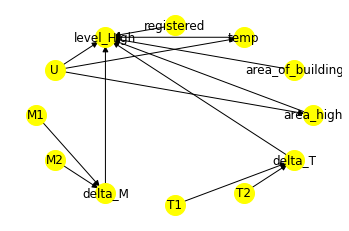

In [177]:
#Creating the 
causal_graph = """
digraph {
M1;
M2;
delta_M;
T1;
T2;
delta_T;
area_high;
area_of_building;
temp;
registered;
level_High;
U[label="Unobserved Confounders"];
M1 -> delta_M; M2 -> delta_M; 
T1 -> delta_T; T2 -> delta_T; 
delta_T -> level_High; area_high -> level_High; area_of_building -> level_High;
temp -> level_High; delta_M -> level_High; registered -> level_High;
U -> level_High; U -> temp; U->area_high;

}
"""

from dowhy import CausalModel
from IPython.display import Image, display
model= CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment='area_high',
        outcome='level_High')
model.view_model()

In [178]:
#Identify the causal effect
estimands = model.identify_effect(proceed_when_unidentifiable=True)
print(estimands)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(level_High|T1,registered,delta_T,M1,area_of_building,
d[area_high]                                                                  

                    
T2,M2,delta_M,temp))
                    
Estimand assumption 1, Unconfoundedness: If U→{area_high} and U→level_High then P(level_High|area_high,T1,registered,delta_T,M1,area_of_building,T2,M2,delta_M,temp,U) = P(level_High|area_high,T1,registered,delta_T,M1,area_of_building,T2,M2,delta_M,temp)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [179]:
#Causal Effect Estimation
estimate = model.estimate_effect(estimands,method_name = "backdoor.propensity_score_weighting")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(level_High|T1,registered,delta_T,M1,area_of_building,
d[area_high]                                                                  

                    
T2,M2,delta_M,temp))
                    
Estimand assumption 1, Unconfoundedness: If U→{area_high} and U→level_High then P(level_High|area_high,T1,registered,delta_T,M1,area_of_building,T2,M2,delta_M,temp,U) = P(level_High|area_high,T1,registered,delta_T,M1,area_of_building,T2,M2,delta_M,temp)

## Realized estimand
b: level_High~area_high+T1+registered+delta_T+M1+area_of_building+T2+M2+delta_M+temp
Target units: ate

## Estimate
Mean value: 0.008125075054742054



/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [180]:
refutel_random = model.refute_estimate(estimands,estimate, "random_common_cause")
refutel_subset = model.refute_estimate(estimands,estimate, "data_subset_refuter")
refutel_placebo = model.refute_estimate(estimands,estimate, "placebo_treatment_refuter")

print("refutel_random:" ,refutel_random)
print("refutel_subset:" ,refutel_subset)
print("refutel_placebo:" ,refutel_placebo)

/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


refutel_random: Refute: Add a Random Common Cause
Estimated effect:0.008125075054742054
New effect:0.008125075054742054



/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

refutel_subset: Refute: Use a subset of data
Estimated effect:0.008125075054742054
New effect:0.008132635698961133
p value:0.45

refutel_placebo: Refute: Use a Placebo Treatment
Estimated effect:0.008125075054742054
New effect:-2.1496167573853098e-05
p value:0.48



## area of building

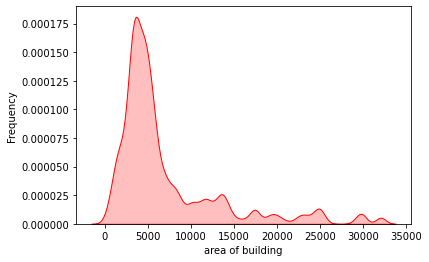

In [181]:
h = sns.kdeplot(training['area_of_building'], color="Red", shade = True)
h.set_xlabel("area of building")
h.set_ylabel("Frequency")
plt.show()

In [183]:
training = data_Label[['M1', 'M2', 'delta_M', 'T1', 'T2', 'delta_T','area', 'area_of_building', 'temp','registered', 'level_High']].copy()
training['area_of_building_high']= data_Label['area_of_building'].astype(float, errors = 'raise').apply(lambda x: True if x>7066.471478 else False)
training.describe()

M1             M2        delta_M             T1  \
count  164792.000000  164792.000000  164792.000000  164792.000000   
mean      137.630041     133.575492       4.054543      76.274687   
std       111.781591     111.300147       7.543280      11.042464   
min         0.800000       0.010000     -25.600000      40.010000   
25%        75.080000      71.470000      -0.190000      66.880000   
50%       113.040000     107.590000       2.000000      74.900000   
75%       157.250000     152.680000       7.000000      85.220000   
max      1675.390000    1659.390000     514.310000     116.990000   

                  T2        delta_T           area  area_of_building  \
count  164792.000000  164792.000000  164792.000000     164792.000000   
mean       50.367019      25.907669    3476.709410       7066.471478   
std         5.812095       8.006409    2268.625664       6322.387367   
min         6.380000       2.050000     169.400000        169.400000   
25%        46.310000      20.310000    2143.700000       3418.500000   
50%        49.760000      25.470000    2943.700000       4767.000000   
75%        54.260000      31.590000    3964.800000       7943.900000   
max        87.510000      62.710000   18801.100000      32030.920000   

                temp     registered  
count  164792.000000  164792.000000  
mean       -7.304365       0.749757  
std        10.247033       0.433154  
min       -32.582617       0.000000  
25%       -14.349412       0.000000  
50%        -7.930418       1.000000  
75%         0.582159       1.000000  
max        16.963864       1.000000

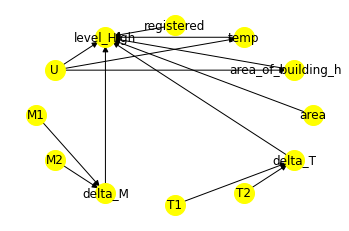

In [184]:
#Creating the 
causal_graph = """
digraph {
M1;
M2;
delta_M;
T1;
T2;
delta_T;
area;
area_of_building_high;
temp;
registered;
level_High;
U[label="Unobserved Confounders"];
M1 -> delta_M; M2 -> delta_M; 
T1 -> delta_T; T2 -> delta_T; 
delta_T -> level_High; area_of_building_high -> level_High; area -> level_High;
temp -> level_High; delta_M -> level_High; registered -> level_High;
U -> level_High; U -> temp; U->area_of_building_high;

}
"""

from dowhy import CausalModel
from IPython.display import Image, display
model= CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment='area_of_building_high',
        outcome='level_High')
model.view_model()

In [185]:
#Identify the causal effect
estimands = model.identify_effect(proceed_when_unidentifiable=True)
print(estimands)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
────────────────────────(Expectation(level_High|T1,registered,delta_T,M1,T2,M2
d[area_of_building_high]                                                      

                    
,delta_M,temp,area))
                    
Estimand assumption 1, Unconfoundedness: If U→{area_of_building_high} and U→level_High then P(level_High|area_of_building_high,T1,registered,delta_T,M1,T2,M2,delta_M,temp,area,U) = P(level_High|area_of_building_high,T1,registered,delta_T,M1,T2,M2,delta_M,temp,area)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [186]:
#Causal Effect Estimation
estimate = model.estimate_effect(estimands,method_name = "backdoor.propensity_score_weighting")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
────────────────────────(Expectation(level_High|T1,registered,delta_T,M1,T2,M2
d[area_of_building_high]                                                      

                    
,delta_M,temp,area))
                    
Estimand assumption 1, Unconfoundedness: If U→{area_of_building_high} and U→level_High then P(level_High|area_of_building_high,T1,registered,delta_T,M1,T2,M2,delta_M,temp,area,U) = P(level_High|area_of_building_high,T1,registered,delta_T,M1,T2,M2,delta_M,temp,area)

## Realized estimand
b: level_High~area_of_building_high+T1+registered+delta_T+M1+T2+M2+delta_M+temp+area
Target units: ate

## Estimate
Mean value: 0.009213611626119984



/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [187]:
refutel_random = model.refute_estimate(estimands,estimate, "random_common_cause")
refutel_subset = model.refute_estimate(estimands,estimate, "data_subset_refuter")
refutel_placebo = model.refute_estimate(estimands,estimate, "placebo_treatment_refuter")

print("refutel_random:" ,refutel_random)
print("refutel_subset:" ,refutel_subset)
print("refutel_placebo:" ,refutel_placebo)

/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

refutel_random: Refute: Add a Random Common Cause
Estimated effect:0.009213611626119984
New effect:0.01010543981122097

refutel_subset: Refute: Use a subset of data
Estimated effect:0.009213611626119984
New effect:0.009496618300343752
p value:0.31

refutel_placebo: Refute: Use a Placebo Treatment
Estimated effect:0.009213611626119984
New effect:3.833367172579924e-05
p value:0.47

